In [1]:
import os
#os.chdir("/home/simon/maskset-static/content/blog/timing_diagrams/")
%config InlineBackend.figure_formats = ['svg']

In [169]:
import vcdvcd
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

def condition_expand(signal, endtime: float):
    """Condition and expand VCD signal to endtime."""
    signal.tv = vcdvcd.condition_signal_tv(signal.tv)
    x, y = list(zip(*signal.tv))
    x, y = vcdvcd.expand_signal(x, y, endtime)
    return np.array(x, dtype=float), np.array(y, dtype=float)
    
@dataclass
class Signal:
    title: str
    x: np.array
    y: np.array
    xscale: float
    endtime: float

    @classmethod
    def load(cls, vcd: vcdvcd.VCDVCD, signal_id: str, title: str, endtime: float):
        xscale = float(vcd.timescale["timescale"])
        x, y = condition_expand(vcd[signal_id], endtime)
        return cls(title=title, x=np.asarray(x), y=np.asarray(y), xscale=xscale, endtime=endtime)
    
def get_signals(fname="vlt_dump.vcd"):
    vcd = vcdvcd.VCDVCD(fname)
    signal_tags = (("TOP.signal_in[11:0]","AIN"),
        ("TOP.clk", "CLK"),
        ("TOP.enable", "EN"),
        ("TOP.data_out[11:0]", "ADCOUT"))
    
    endtime = max(vcd[name].endtime for name, _ in signal_tags)

    signals: List[Signal] = [
        Signal.load(vcd=vcd, signal_id=signal_id, title=title, endtime=endtime) 
        for signal_id, title in signal_tags]
    return signals

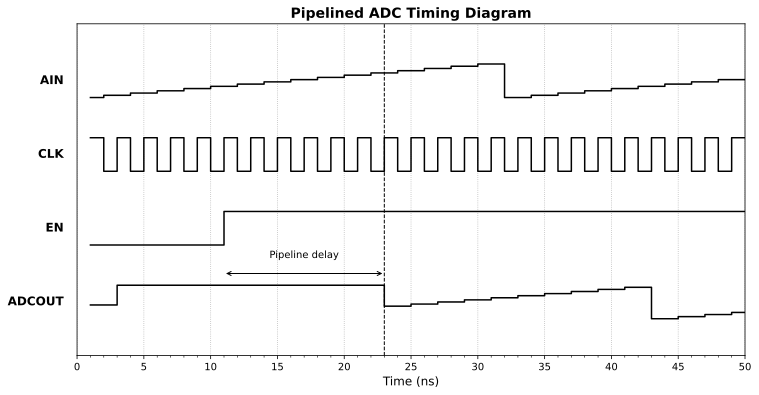

In [170]:
def plot_timing_diagram(signals):
    '''
    Normalize signals and space them out on one axis.
    '''
    fig, ax = plt.subplots(figsize=(12, 6))
    spacing = 2.2

    # Digital signals
    for i, signal in enumerate(signals):
        y_offset = -i * spacing
        endtime = signal.endtime
        xscale = signal.xscale
        x = signal.x*xscale*1e9
        
        y_range = (max(signal.y)-min(signal.y))
        y = np.zeros_like(signal.y) if y_range == 0 else signal.y/y_range
    
        label = signal.title

        # Normalize: each digital waveform ranges from baseline (y_offset) to y_offset+1
        ax.step(x, y_offset + y, where="post", color="black", lw=1.5)
        ax.hlines(y_offset, 0, endtime * xscale, color="0.8",
                  lw=0.5, linestyle="--")  # baseline
        ax.text(-1, y_offset + 0.5, label, ha="right", va="center",
                fontsize=12, weight="bold")
        y_offset -= spacing

    # Formatting
    ax.set_ylim(-spacing*(len(signals)-1) - spacing/2, spacing)
    ax.set_xlabel("Time (ns)", fontsize=12)
    ax.set_yticks([])
    ax.set_title("Pipelined ADC Timing Diagram", fontsize=14, weight="bold")

    # Gridlines
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
    ax.grid(axis="x", which="major", linestyle=":", color="0.7")

    # Example timing annotations (positioned relative to digital baselines)
    valid_data_x = 23.
    annotate_arrow(ax, 11, valid_data_x, -5.25, "Pipeline delay")

    # Vertical event marker
    ax.axvline(valid_data_x, color="black", linestyle="--", lw=1.0)

    return fig, [ax]
    
signals = get_signals()
fig, axes = plot_timing_diagram(list(signals))
axes[0].set_xlim(0, 50)
fig.savefig("adc_timing_model.svg", bbox_inches="tight")
plt.show()

In [175]:
import importlib
import wavedrom
importlib.reload(wavedrom)

st = '''
{ "signal": [
  { "name": "Analog Signal In", "wave": "z================", "data":["D0", "D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9", "D10", "D11", "D12", "D13", "D14", "D15", "D16", "D17", "D18", "D19"]},
  { "name": "Clock", "wave": "|n..............."},
  { "name": "Enable",       "wave": "0....1..........."},
  { "name": "ADC Data Out", "wave": "|1.........======", "data":["D4", "D5", "D6", "D7", "D8", "D9", "D10", "D11", "D12", "D13"]},
]}
'''
svg = wavedrom.render(st)
svg.saveas("adc_timing_model_wavedrom.svg")

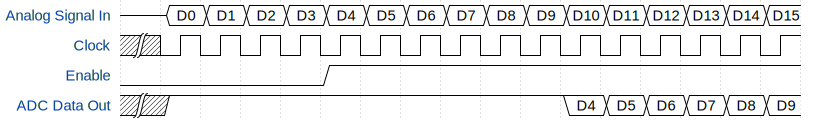

In [176]:
from IPython.display import SVG
SVG("adc_timing_model_wavedrom.svg")